# Geodesic Learning Using Updated Distance Metrics

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomTreesEmbedding
from rerf.urerf import UnsupervisedRandomForest

In [2]:
# generate the linear simulation
def linear(n_sample=1000):
    t = np.linspace(0, 1, n_sample)
    data = np.c_[4*t, 6*t, 9*t]
    return data

# generate the helix simulation
def helix(n_sample=1000):
    t = np.linspace(2*np.pi, 9*np.pi, n_sample)
    data = np.c_[t*np.cos(t), t*np.sin(t), t]
    return data

# generate the sphere simulation
def sphere(n_sample=1000):
    data = []
    offset = 2.0/n_sample
    increment = np.pi*(3.0-np.sqrt(5))
    for i in range(n_sample):
        y = i*offset+offset/2-1
        r = np.sqrt(1-y**2)
        phi = (i+1)*increment
        x = np.cos(phi) * r
        z = np.sin(phi) * r
        data.append([x, y, z])
    return 9*np.array(data)

# generate the Guassian mixture simulation
def Guassian_mixture(n_sample=1000):
    data = make_blobs(
        centers=[[-3, -3, -3], [0, 0, 0], [3, 3, 3]],
        cluster_std=[0.3, 0.3, 0.4],
        random_state=0, n_samples=n_sample, n_features=3)[0]
    return data

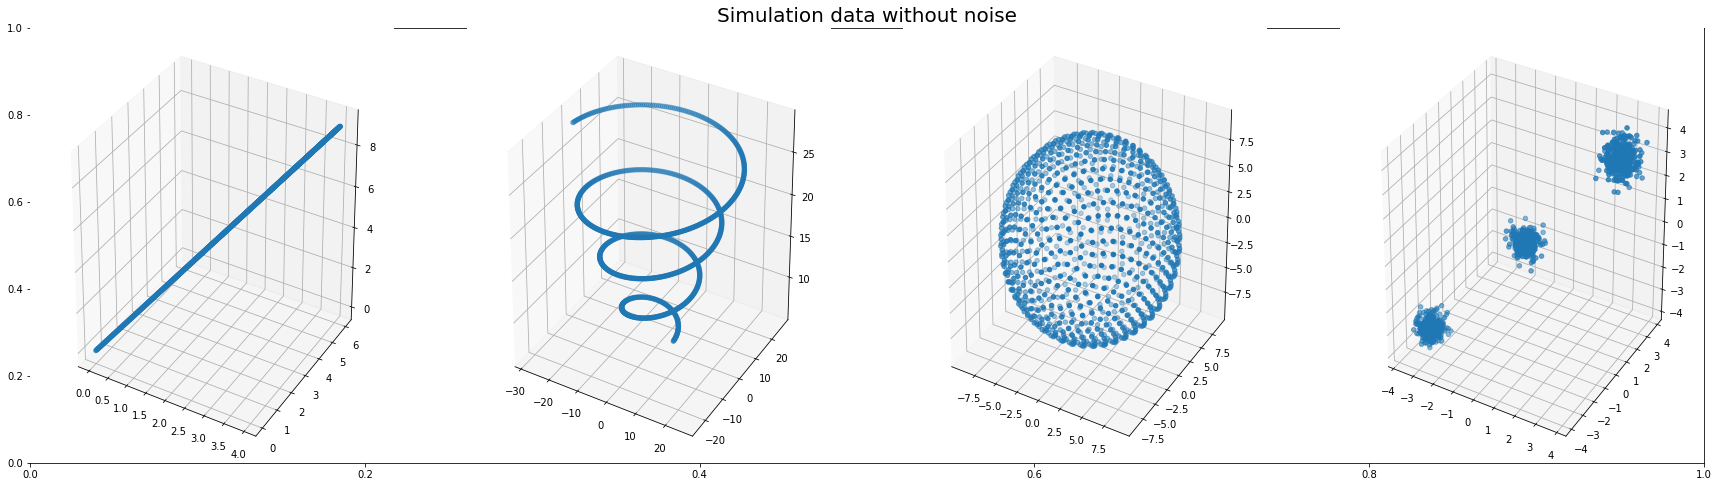

In [3]:
# organize the data and algorithms
data = [(linear(), 'linear'), (helix(), 'helix'), (sphere(), 'sphere'), (Guassian_mixture(), 'Guassian mixture')]

fig = plt.figure(figsize=(30, 8))
plt.title('Simulation data without noise', fontsize=20)

algorithm = [(UnsupervisedRandomForest(n_estimators=100, max_depth=5, random_state=0)), 
             (RandomTreesEmbedding(n_estimators=100, max_depth=5, random_state=0)), 
             (RandomTreesEmbedding(n_estimators=100, max_depth=5, random_state=0))]

# plot the simulation data
for i, (samples, sim_title) in enumerate(data):
    
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    
    ax.scatter3D(samples[:, 0], samples[:, 1], samples[:, 2])

In [4]:
# depth of nearest common ancestor
def NCA(clf,samples): 
    
    n_estimator = len(clf.estimators_)
    path = np.array(clf.decision_path(samples)[0].todense())
    d = path.dot(path.T)
    d_nca = (d.max() - d) / n_estimator
    
    return d_nca

In [5]:
# length of shortest path
def SP(clf, samples): 
    
    n_sample = len(samples)
    n_estimator = len(clf.estimators_)
    path = np.array(clf.decision_path(samples)[0].todense())
    depth = np.array((path*path).sum(1))
    depth = np.tile(depth, (n_sample, 1))
    depth = depth+depth.T
    d = depth-2*path.dot(path.T)
    d_shortest_path = d / n_estimator
    
    return d_shortest_path

In [6]:
# the original similarity matrix of USPORF
def sim(clf): 
    
    return 1-clf.transform()

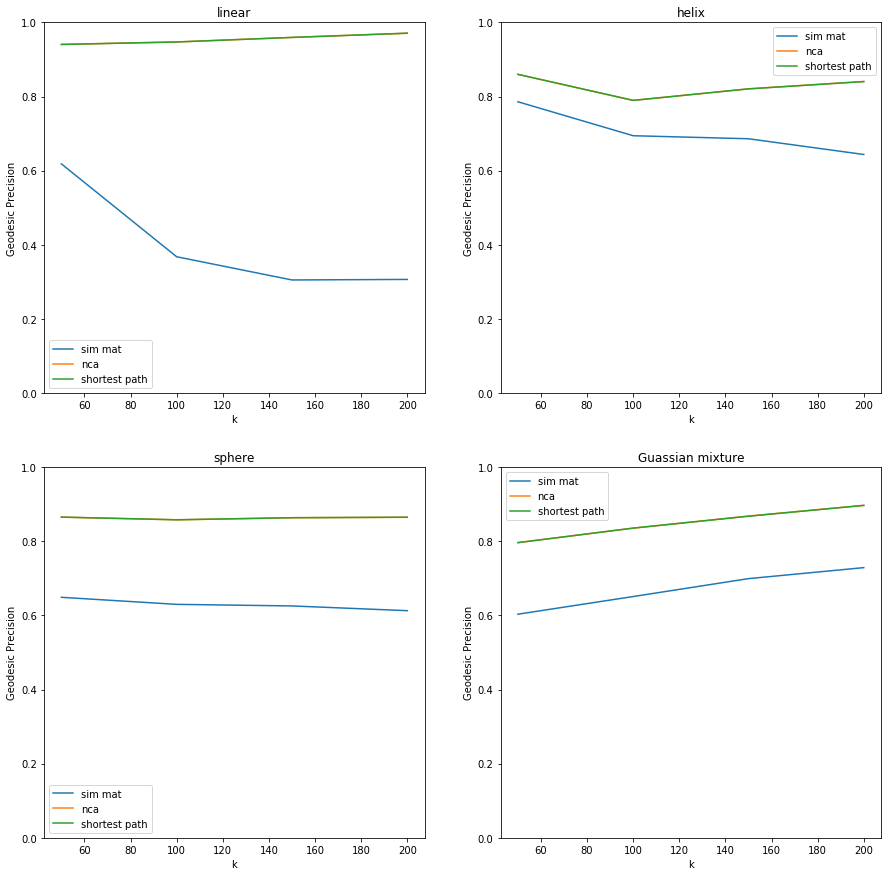

In [7]:
# compare the performance on four different simulations on four different k, 50, 100, 150 and 200
fig = plt.figure(figsize=(15, 15))
plt.title('Geodesic Precision on Simulated Datasets', fontsize=20)

for i, (samples, sim_title) in enumerate(data): 
    plt.subplot(2, 2, i+1)
    plt.title(sim_title)
    ks = [50, 100, 150, 200]
    prec = np.zeros([4, 3])
    for k in range(4):
        nn_relevant = NearestNeighbors(n_neighbors=ks[k])
        nn_relevant.fit(samples)
        relevant_samples = nn_relevant.kneighbors(samples, return_distance=False)
        nn_retrieved = NearestNeighbors(n_neighbors=ks[k], metric='precomputed')
        for j, (clf) in enumerate(algorithm): 
            clf.fit(samples)
            if j == 0: 
                distance = sim(clf)
            elif j == 1: 
                distance = NCA(clf, samples)
            elif j == 2: 
                distance = SP(clf, samples)
            nn_retrieved = NearestNeighbors(n_neighbors=ks[k], metric='precomputed')
            nn_retrieved.fit(distance)
            retrieved_samples = nn_retrieved.kneighbors(distance, return_distance=False)
            precision = 0
            for l in range(1000): 
                a = relevant_samples[l].tolist()
                b = retrieved_samples[l].tolist()
                precision += len(set(a)&set(b))/ks[k]
            precision /= 1000
            prec[k, j] = precision
    plt.plot(ks, prec[:, 0], label='sim mat')
    plt.plot(ks, prec[:, 1], label='nca')
    plt.plot(ks, prec[:, 2], label='shortest path')
    plt.ylim(0, 1)
    plt.xlabel('k')
    plt.ylabel('Geodesic Precision')
    plt.legend()

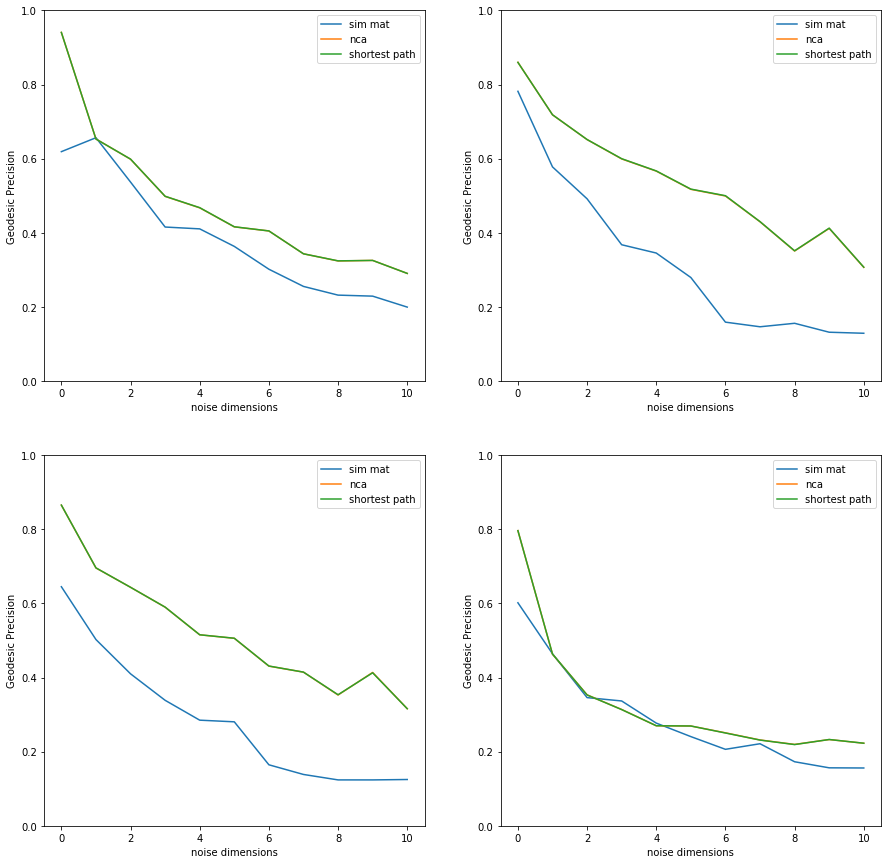

In [8]:
# compare the performance on four different simulations with noise dimensions of 0 to 10
fig = plt.figure(figsize=(15, 15))
plt.title('Geodesic Precision with Guassian noise dimensions', fontsize=20)

for i, (samples, sim_title) in enumerate(data): 
    plt.subplot(2, 2, i+1)
    dim_noise = range(11)
    prec = np.zeros([11, 3])
    for k in range(11):
        nn_relevant = NearestNeighbors(n_neighbors=50)
        nn_relevant.fit(samples)
        relevant_samples = nn_relevant.kneighbors(samples, return_distance=False)
        noise = np.random.randn(samples.shape[0], dim_noise[k])
        noised_samples = np.hstack((samples, noise))
        nn_retrieved = NearestNeighbors(n_neighbors=50, metric='precomputed')
        for j, (clf) in enumerate(algorithm): 
            clf.fit(noised_samples)
            if j == 0: 
                distance = sim(clf)
            elif j == 1: 
                distance = NCA(clf, noised_samples)
            elif j == 2: 
                distance = SP(clf, noised_samples)
            nn_retrieved = NearestNeighbors(n_neighbors=50, metric='precomputed')
            nn_retrieved.fit(distance)
            retrieved_samples = nn_retrieved.kneighbors(distance, return_distance=False)
            precision = 0
            for l in range(1000): 
                a = relevant_samples[l].tolist()
                b = retrieved_samples[l].tolist()
                precision += len(set(a)&set(b))/50
            precision /= 1000
            prec[k, j] = precision
    plt.plot(dim_noise, prec[:, 0], label='sim mat')
    plt.plot(dim_noise, prec[:, 1], label='nca')
    plt.plot(dim_noise, prec[:, 2], label='shortest path')
    plt.ylim(0, 1)
    plt.xlabel('noise dimensions')
    plt.ylabel('Geodesic Precision')
    plt.legend()